Nahraj obsahový a štýlový obrázok.


Saving 1.jpg to 1 (10).jpg
Saving 2.jpg to 2 (10).jpg
Step 0, Total loss: 2117267968.0
Step 50, Total loss: 33375872.0
Step 100, Total loss: 16733608.0
Step 150, Total loss: 12206539.0
Step 200, Total loss: 10024668.0
Step 250, Total loss: 8703616.0


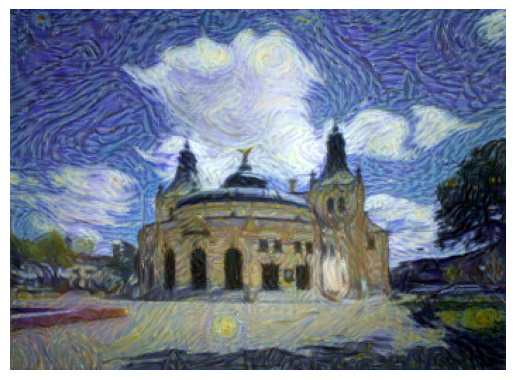

In [ ]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os

# Funkcia na načítanie obrázkov
def load_image(image_path, max_size=256, shape=None): # nacita obrázok a prevedie na RGB
    image = Image.open(image_path).convert('RGB')  # upravenie veľkosti na max_size alebo zachovanie pôvodnej veľkosti
    size = max_size if max(image.size) > max_size else max(image.size)
    if shape is not None:
        size = shape
    # normalizácia a transformácia na tenzor
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = transform(image).unsqueeze(0)
    return image

# Zobrazenie obrázka
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

# Vypočet Gramovej matice
def gram_matrix(tensor):
    _, d, h, w = tensor.size() # extrahuje rozmery tenzora
    tensor = tensor.view(d, h * w) # reshape na dvojrozmerný tvar
    gram = torch.mm(tensor, tensor.t()) # maticový súčin
    return gram

# Extrakcia vlastností obrázka
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'   #obsahová vrstva
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Style transfer
def style_transfer(content, style, model, content_weight=1e2, style_weight=1e7, steps=300):
    target = content.clone().requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.05)

    content_features = get_features(content, model)
    style_features = get_features(style, model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    for i in range(steps):
        target_features = get_features(target, model)

        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

        style_loss = 0
        for layer in style_grams:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = torch.mean((target_gram - style_gram) ** 2)
            _, d, h, w = target_feature.shape
            style_loss += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f'Step {i}, Total loss: {total_loss.item()}')

    return target

# 1. Nahraj obrázky z počítača
print("Nahraj obsahový a štýlový obrázok.")
uploaded = files.upload()

# Ulož nahrané obrázky
content_path = list(uploaded.keys())[0]
style_path = list(uploaded.keys())[1]

# 2. Načítanie obrázkov
content = load_image(content_path)
style = load_image(style_path, shape=content.shape[-2:])

# 3. Načítanie predtrénovanej VGG19 siete
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

# 4. Presun na GPU, ak je dostupné
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = content.to(device)
style = style.to(device)
vgg = vgg.to(device)

# 5. Spustenie prenášania štýlu
target = style_transfer(content, style, vgg)

# 6. Zobrazenie výsledného obrázka
plt.imshow(im_convert(target))
plt.axis('off')
plt.show()
